In [1]:
import numpy as np
import sys
import pyvista as pv
import os
import torch
import matplotlib.pyplot as plt

In [2]:
class IGBReader:
    """ 
    class IGBReader: reads an igb file
    """
    
    def __init__(self):
        self.__header: dict     = None
        self.__data: np.ndarray = None
        self.__filename: str    = None
        self.__ndiff: int       = 0
        self.__head_size: int   = 256

    def read(self,igbfname: str):
        """ read(igbfname):
        reads the IGB file igbfname and fills the header and data attributes.
        """
        self.__filename = igbfname
        try:
            parsed_header = self.__parse_header()

            #now read the data and create an array        
            with open(self.__filename,'rb') as f:
                y = np.fromfile(f,'f4')
            y        = y[self.__head_size:]
            nt       = parsed_header['t']
            nx       = parsed_header['x']            
            nentries = y.shape[0]
            ntot     = nt*nx
            self.__ndiff = nentries-ntot
            
            if(nentries>ntot):
                # More values than expected
                print('Warning: problem with the igb file',flush=True)
                print('Discarding the last {} elements'.format(self.__ndiff))
                y  = y[:ntot] 
            elif(nentries<ntot):  
                #less values than expected nentries<ntot
                nt = nentries//nx
                if(nt==0):
                    print('ERROR: y too short!')
                    print('({} elements; expected {} (problems with the igb file)'.format(nentries,ntot))
                    sys.exit()
                else:
                    ntot     = nt*nx
                    y        = y[:ntot]
                    missing = nentries%nx
                    print('Warning: problem with the ifgb file',flush=True)                    
                    print('Missing {} elements to reach {}'.format(missing,parsed_header['t'])) 
                    print('Reshaping to {} time steps'.format(nt))
            else:
                print('file is ok')
            parsed_header['t'] = nt
            y = np.reshape(y,(nt,nx))
            self.__header = parsed_header
            self.__data   = np.copy(y)
        except ValueError:
            print('error with {0}'.format(self.__filename) )


    def header(self) ->dict :
        """header(): returns the header dict"""
        return(self.__header)

    def data(self) ->np.ndarray :
        """data(): returns the numpy array that contains the data"""
        return(self.__data)

    def filename(self) ->str :
        """filename(): returns the file name that contained the data"""
        return(self.__filename)

    def ndiff(self) ->int :
        """ndiff(): returns the number of entries in excess/missing in the original file"""
        return(self.__ndiff)

    def org_t(self) ->float:
        """org_t(): returns the time origin"""
        return(self.__header['org_t'])
        
    def nt(self) -> int:
        """nt(): returns the total number of time steps"""
        return(self.__header['t'])
    
    def nx(self) -> int:
        """nx(): returns the x space dimension"""
        return(self.__header['x'])

    def ny(self) -> int:
        """ny(): returns the y space dimension"""
        return(self.__header['y'])

    def nz(self) -> int:
        """nz(): returns the z space dimension"""
        return(self.__header['z'])

    def dim_t(self) ->float:
        """dim_t(): returns the temporal dimension""" 
        return(self.__header['dim_t'])
    
    def dt(self) ->float:
        """dt(): returns the time step (nan if nt=1)"""
        if(self.nt()>1):
            return(self.dim_t()/(self.nt()-1))
        else:
            return(np.nan)

    def timevalues(self,shifted:bool = False) ->np.ndarray:
        """timevalues(shifted=False): returns a numpy array with the time axis
        if shifted = True, it shifts the time values to have 0 as the first one
        """
        tline = self.dt()*np.arange(self.nt())
        if shifted:
            return(tline)
        else:
            return(self.org_t()+tline)


    def __parse_header(self) ->dict :
        ''' parse_header():
        parses the header of the IGB file.
        '''
        parsed_header = {}
        int_keys = ['x','y','z','t']
        try:
            with open(self.__filename,'rb') as f:
                header = f.read(self.__head_size)
            header = header.decode("utf-8")
            for jj in header.strip().split():
                [key,val]=jj.split(':')
                if(val.isdigit()):
                    if key in int_keys:
                        parsed_header[key]=int(val)
                    else:
                        parsed_header[key]=float(val)
                else:
                    parsed_header[key]=val            
            # Now add some keys that might miss
            if not 'y' in parsed_header.keys():
                parsed_header['y'] = int(1)            
            if not 'z' in parsed_header.keys():
                parsed_header['z'] = int(1)
            if not 'org_t' in parsed_header.keys():
                parsed_header['org_t'] = float(0)
            if not 'dim_t' in parsed_header.keys():
                parsed_header['dim_t'] = float(parsed_header['t']-1 )
            if not 'unites_x' in parsed_header.keys():
                parsed_header['unites_x'] = 'unk'
            if not 'unites_y' in parsed_header.keys():
                parsed_header['unites_y'] = 'unk'
            if not 'unites_z' in parsed_header.keys():
                parsed_header['unites_z'] = 'unk'
            if not 'unites_t' in parsed_header.keys():
                parsed_header['unites_t'] = 'unk'
            if not 'unites' in parsed_header.keys():
                parsed_header['unites'] = 'unk'
            if not 'facteur' in parsed_header.keys():
                parsed_header['facteur'] = 1
            if not 'zero' in parsed_header.keys():
                parsed_header['zero'] = 0
            return(parsed_header)
                                  
        except Exception as err:
            print(f"Unexpected {err=}, {type(err)=}")
            raise

In [3]:
reader = IGBReader()
reader.read("/home/bzhou6/Downloads/vm.igb")
carp_solution = reader.data()[1:-1]

cor_solution = torch.load("/home/bzhou6/Downloads/Vm.pt").numpy()

carp_solution = carp_solution
cor_solution = cor_solution

file is ok


In [4]:
cor_solution.shape

(599, 637480)

In [5]:
carp_solution.shape

(599, 637480)

In [6]:
diff_list = []


In [7]:
# np.argsort(np.sum(carp_solution - cor_solution, axis=1))[-1]

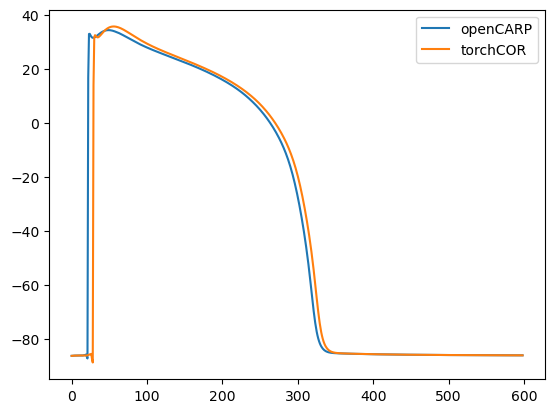

In [8]:
carp = []
cor = []
largest_diff_node = 89382
for i in range(599):
    carp.append(carp_solution[i][largest_diff_node])
    cor.append(cor_solution[i][largest_diff_node])
    
plt.plot(carp, label="openCARP")
plt.plot(cor, label="torchCOR")
plt.legend()

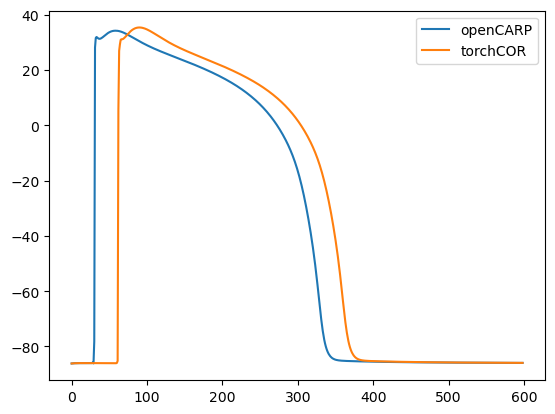

In [15]:
carp = []
cor = []
largest_diff_node = 89
for i in range(599):
    carp.append(carp_solution[i][largest_diff_node])
    cor.append(cor_solution[i][largest_diff_node])
    
plt.plot(carp, label="openCARP")
plt.plot(cor, label="torchCOR")
plt.legend()

In [10]:
for i in range(599):
    diff = np.linalg.norm(carp_solution[i] - cor_solution[i]) / np.linalg.norm(carp_solution[i])
    print(diff)

0.008500494
0.01808603
0.028917287
0.040752567
0.053006805
0.07771268
0.096447885
0.12084015
0.1542067
0.19344944
0.22835256
0.25893798
0.29367754
0.33133402
0.3737451
0.41459355
0.45202103
0.48793215
0.5221742
0.5567302
0.59266573
0.630924
0.6702919
0.70958
0.7502904
0.7937602
0.8442756
0.89722943
0.9496505
1.0008541
1.0514404
1.1024481
1.1512332
1.1963732
1.2408196
1.2865049
1.3331853
1.3796136
1.4258108
1.4738649
1.523924
1.5784249
1.6316612
1.6793859
1.7182243
1.7457781
1.7694545
1.7861447
1.7972928
1.8022374
1.8022325
1.7956088
1.7796848
1.7540476
1.7201867
1.6802295
1.6386834
1.5965139
1.5503105
1.5021052
1.4543086
1.4071548
1.3605314
1.3142921
1.2688497
1.223603
1.1775873
1.1310176
1.0836737
1.0353106
0.9889113
0.94207054
0.8971216
0.8525997
0.8069429
0.76011056
0.7113078
0.65934443
0.6076553
0.5573366
0.50889075
0.4619241
0.41232276
0.36464927
0.31984797
0.27527878
0.23185177
0.18993455
0.1500769
0.11650854
0.09609215
0.094693795
0.09633123
0.097931534
0.099476516
0.1009597
0.1